<a href="https://colab.research.google.com/github/Shreya-07/CMPE297_Assignment2/blob/main/Assignment2_Partb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Node classification using GAT/GCN
**By : Shreya Nimbhorkar**

- a graph: this notebook uses the Cora dataset from The dataset consists of academic publications as the nodes and the citations between them as the links: if publication A cites publication B, then the graph has an edge from A to B. The nodes are classified into one of seven subjects, and our model will learn to predict this subject.
- an algorithm: this notebook uses a Graph Convolution Network (GCN). The core of the GCN neural network model is a "graph convolution" layer. This layer is similar to a conventional dense layer, augmented by the graph adjacency matrix to use information about a node's connections. 

Graph Convolutional Networks (GCN): Semi-Supervised Classification with Graph Convolutional Networks. 


##Install StellarGraph

In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 6.4 MB/s 
     |████████████████████████████████| 500 kB 41.1 MB/s 
     |████████████████████████████████| 120 kB 42.1 MB/s 
     |████████████████████████████████| 1.6 MB 41.3 MB/s 
     |████████████████████████████████| 82 kB 448 kB/s 
     |████████████████████████████████| 41 kB 571 kB/s 


In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

##Import Necessary libraries

In [ ]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Data Preparation

### Loading the CORA network

We can retrieve a StellarGraph graph object holding this Cora dataset using the Cora loader. It also provides us with the ground-truth node subject classes. This function is implemented using Pandas


In [ ]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

The `info` method can help us verify that our loaded graph matches the description:

In [ ]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories, with some categories more common than others:

In [ ]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn's train_test_split functions to do this.

Here we're taking 140 node labels for training, 500 for validation, and the rest for testing.

In [ ]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

Note using stratified sampling gives the following counts:

In [ ]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,42
Probabilistic_Methods,22
Genetic_Algorithms,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

In [ ]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

## 2. Creating the GCN layers

A machine learning model in StellarGraph consists of a pair of items:

- the layers themselves, such as graph convolution, dropout
- a data generator to convert the core graph structure and node features into a format that can be fed into the Keras model for training or prediction

GCN is a full-batch model and we're doing node classification here, which means the `FullBatchNodeGenerator` class is the appropriate generator for our task. StellarGraph has many generators in order to support all its many models and tasks

Specifying the `method='gcn'` argument to the `FullBatchNodeGenerator` means it will yield data appropriate for the GCN algorithm specifically, by using the normalized graph Laplacian matrix to capture the graph structure.

In [ ]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [ ]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [ ]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

To create a Keras model we now expose the input and output tensors of the GCN model for node prediction, via the `GCN.in_out_tensors` method:

In [ ]:
x_inp, x_out = gcn.in_out_tensors()

x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices')>

In [ ]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

## 3. Training and evaluating

### Training the model

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


As we're training the model, we'll want to also keep track of its generalisation performance on the validation set, which means creating another data generator, using our FullBatchNodeGenerator we created above.

In [ ]:
val_gen = generator.flow(val_subjects.index, val_targets)

We can directly use the `EarlyStopping` functionality ([docs](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)) offered by Keras to stop training if the validation accuracy stops improving.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

We've now set up our model layers, our training data, our validation data and even our training callbacks, so we can now train the model using the model's fit method 

In [ ]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 2s - loss: 1.9398 - acc: 0.1786 - val_loss: 1.8967 - val_acc: 0.3680 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.8836 - acc: 0.3643 - val_loss: 1.8403 - val_acc: 0.4300 - 281ms/epoch - 281ms/step
Epoch 3/200
1/1 - 0s - loss: 1.8210 - acc: 0.4143 - val_loss: 1.7743 - val_acc: 0.4620 - 295ms/epoch - 295ms/step
Epoch 4/200
1/1 - 0s - loss: 1.7316 - acc: 0.5000 - val_loss: 1.7029 - val_acc: 0.4760 - 327ms/epoch - 327ms/step
Epoch 5/200
1/1 - 0s - loss: 1.6359 - acc: 0.4714 - val_loss: 1.6268 - val_acc: 0.4700 - 270ms/epoch - 270ms/step
Epoch 6/200
1/1 - 0s - loss: 1.5192 - acc: 0.5214 - val_loss: 1.5482 - val_acc: 0.4560 - 282ms/epoch - 282ms/step
Epoch 7/200
1/1 - 0s - loss: 1.4612 - acc: 0.4857 - val_loss: 1.4710 - val_acc: 0.4600 - 325ms/epoch - 325ms/step
Epoch 8/200
1/1 - 0s - loss: 1.3533 - acc: 0.5714 - val_loss: 1.3925 - val_acc: 0.4780 - 262ms/epoch - 262ms/step
Epoch 9/200
1/1 - 0s - loss: 1.2275 - acc: 0.5571 - val_loss: 1.3131 - val_acc: 0.5140 - 320ms

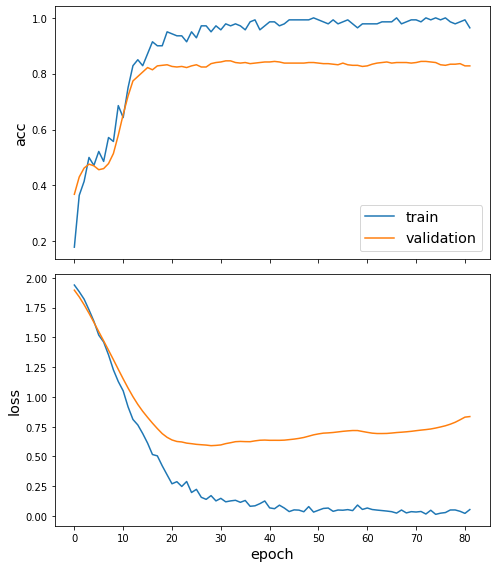

In [ ]:
sg.utils.plot_history(history)

In [ ]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 65ms/step - loss: 0.6889 - acc: 0.8148

Test Set Metrics:
	loss: 0.6889
	acc: 0.8148


### Making predictions with the model

Now let's get the predictions for all nodes. You're probably getting used to it by now, but we use our `FullBatchNodeGenerator` to create the input required and then use one of the model's methods: `predict` ([docs](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict)). This time we _don't_ provide the labels to `flow`, and instead just the nodes, because we're trying to predict these classes without knowing them.

In [ ]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

1/1 [==============================] - 0s 223ms/step


In [ ]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

Let's have a look at a few predictions after training the model:

In [ ]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Reinforcement_Learning,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


In [ ]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [ ]:
emb = embedding_model.predict(all_gen)
emb.shape

1/1 [==============================] - 0s 144ms/step


(1, 2708, 16)

The last GCN layer had output dimension 16, meaning each embedding consists of 16 numbers. Plotting this directly would require a 16 dimensional plot, which is hard for humans to visualise. Instead, we can first project these vectors down to just 2 numbers, making vectors of dimension 2 that can be plotted on a normal 2D scatter plot.


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE  # or PCA

In [ ]:
X = emb.squeeze(0)
X.shape

(2708, 16)

In [ ]:
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(2708, 2)

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for cora dataset'),
 None]

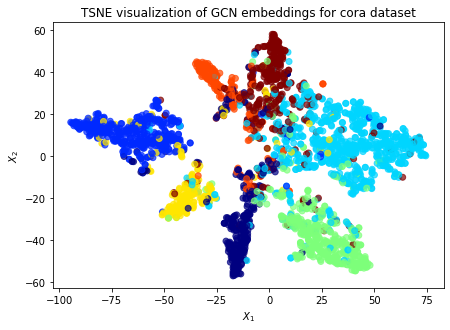

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for cora dataset",
)

## Conclusion

This notebook uses the GCN algorithm to predict the class of nodes. Specifically, the subject of an academic paper in the Cora dataset.

- the graph structure of the dataset, in the form of citation links between papers
- the 1433-dimensional feature vectors associated with each paper

Once the model is trained for prediction:

- predict the classes of nodes
- use the model's weights to compute vector embeddings for nodes